In [1]:
## Imports
import random
import json
import torch

from classes import  CIFAKE_loader, CIFAKE_CNN
from test import test_model, score_preds
from train import get_files, train


torch.manual_seed(11)
random.seed(11)

with open('./config.json') as f:
    config = json.load(f)

model_path = config['model']
src_dir = config['CIFAKE_dir']  # https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data, Dec 11, 14:05

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load data

In [2]:
# load data
data = get_files(src_dir)
trainfiles = data['train']
testfiles = data['test']
trainfiles[0]  # tuple of filepath + class as str
type(trainfiles)

list

In [3]:
# plot example pre/post normalise; cf tutorial code
# import matplotlib.pyplot as plt
# plt.imshow(np.array(Image.open(a.data[0][0])))  #normal img
# c = transform(Image.open(a.data[0][0]))  # post transform & re-normalise,,kind of
# c = c / 2 + 0.5     # unnormalize
# npimg = c.numpy()
# plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.show()


In [4]:
traindata = CIFAKE_loader(trainfiles, batch_size=32)

## Training

Base from AICS course cifar10_tutorial.ipynb

CNN+Linear layers with maxpooling  
Conv2d(3, 6, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Conv2d(6, 16, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Flatten(),  
Linear(16 * 5 * 5, 120),  
ReLU(),  
Linear(120, 84),  
ReLU(),  
Linear(84, 10)  
Sigmoid()  

In [5]:
model = CIFAKE_CNN()
model = train(model, traindata, epochs=10)
#epoch: 0	total loss: 3117.363366410136	avg loss: 0.5611815241062351
#epoch: 1	total loss: 2005.8685185052454	avg loss: 0.3610924425752017


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 1983.3529122769833	avg loss: 0.6346729319286346


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1372.3765247762203	avg loss: 0.4391604879283905


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 1117.0684052407742	avg loss: 0.35746188967704773


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 950.864093799144	avg loss: 0.3042765100157261


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 871.5481884628534	avg loss: 0.2788954203081131


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 823.4627295695245	avg loss: 0.26350807346224786


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 788.9280200451612	avg loss: 0.2524569664144516


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 750.1566405855119	avg loss: 0.2400501249873638


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 703.8395151160657	avg loss: 0.22522864483714103


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 677.8026956729591	avg loss: 0.2168968626153469
Finished Training


In [6]:
# torch.save(model.state_dict(), PATH)

## Testing

In [7]:
# load data
testdata = CIFAKE_loader(testfiles, batch_size=18)

In [8]:
# # load model
# model = CIFAKE_CNN()
# model.load_state_dict(torch.load(PATH))

In [9]:
# predict labels & evaluate with accuracy, precision, recall, f1-score
gold, preds = test_model(model, testdata)

  0%|          | 0/1111 [00:00<?, ?it/s]

In [10]:
thresh_data = {}
for i in range(1, 10):
    thresh = round(i/10, 2)
    thresh_data[thresh] = {metric: score_preds(gold, preds, thresh=thresh)[i]
                           for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score'])}

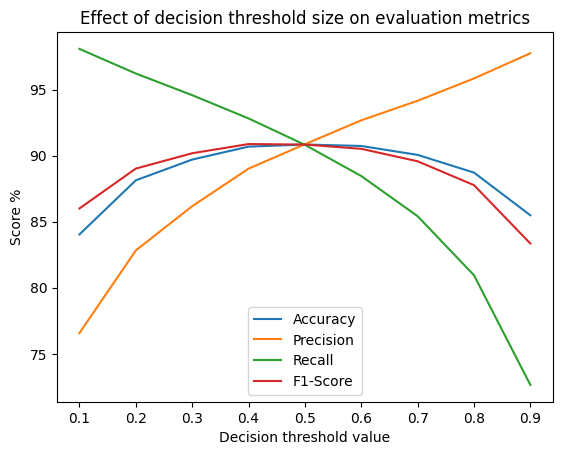

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(thresh_data.values(), index=thresh_data.keys()).mul(100)
fig = df.plot()

fig.set_ylabel('Score %')
fig.set_xlabel('Decision threshold value')
fig.title.set_text('Effect of decision threshold size on evaluation metrics')
fig.legend(loc='lower center')
plt.show()

In [12]:
df

,Accuracy,Precision,Recall,F1-Score
0.1,84.038404,76.575310,98.079808,86.003683
0.2,88.133813,82.825413,96.219622,89.021513
0.3,89.703970,86.176417,94.579458,90.182616
0.4,90.684068,89.017840,92.819282,90.878825
0.5,90.844084,90.864519,90.819082,90.841795
0.6,90.734073,92.676027,88.458846,90.518344
0.7,90.059006,94.157204,85.418542,89.575249
0.8,88.718872,95.843694,80.948095,87.768380
0.9,85.488549,97.752658,72.647265,83.350545
